# Exkurs: Ausreißerentfernung

In dieser Übung geht es um verschiedene Ansätze, Ausreißer in univariaten Datenreihen zu erkennen und zu verarbeiten. Ausreißer sind Beobachtungen, die nicht zu der "typischen" Verteilung der anderen Beobachtungen passen. Das können zum Beispiel extrem große oder kleine Werte sein.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
df = pd.read_csv("../data/Library_Usage.csv",
                                low_memory=False
)

Wenn wir uns die nach der Größe sortierten Werte der Reihe `Total Checkouts` anschauen, so erkennt man, dass über 95% der Werte weniger als 1000 Ausleihen getätigt haben. Wir haben es hier also mit einigen wenigen extrem großen positiven Ausreißern zu tun.

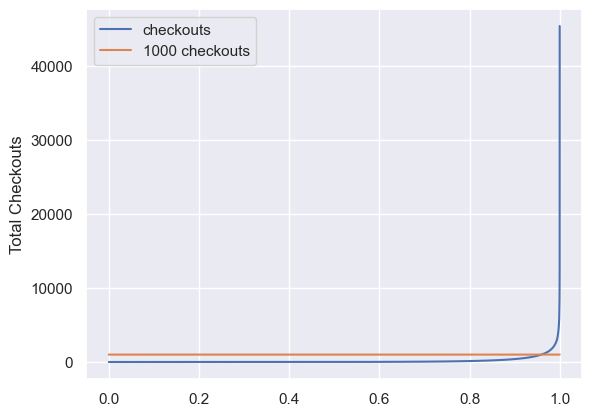

In [2]:
x = np.linspace(0, 1, len(df))
y = df['Total Checkouts'].sort_values()

sns.lineplot(x=x, y=y, estimator=None, label="checkouts")
sns.lineplot(x=x, y=1000, estimator=None, label="1000 checkouts").legend()

Das gleiche Ergebniss erhalten wir, wenn wir uns die oberen **Quantile** anschauen:

In [3]:
df['Total Checkouts'].quantile((0.9, 0.95, 0.99))

0.90     397.0
0.95     841.0
0.99    2428.0
Name: Total Checkouts, dtype: float64

99% der Beobachtungen haben weniger als 2428 Ausleihen. 95% weniger als 841 und 90% weniger als 397 Ausleihen. Den gleichen Trend, wenn auch nicht so stark, erhalten wir für die `Total Renewals`:

In [4]:
df['Total Renewals'].quantile((0.9, 0.95, 0.99))

0.90     167.00
0.95     368.00
0.99    1305.11
Name: Total Renewals, dtype: float64

## Ausreißerentfernung I

Ein häufig angewandtes Verfahren in der Praxis, ist es, die oberen/ unteren `n` Prozent größten/ kleinsten Werte zu entfernen. Zuerst erstellen wir uns zwei boolsche Hilfsvektoren, die die Ausreißer identifizieren:

In [5]:
alpha = 0.015
outlier_checkouts = df['Total Checkouts'] > df['Total Checkouts'].quantile(1-alpha)
outlier_renewals = df['Total Renewals'] > df['Total Renewals'].quantile(1-alpha)

Wie viel Prozent der Beobachtungen, sind für beide Spalten, als Ausreißer markiert (Antwort: knapp 0.6 Prozent):

In [6]:
np.mean(outlier_checkouts & outlier_renewals)

0.006644662953540077

Zuletzt erstellen wir einen Datensatz, indem die Ausreißer für beide Spalten entfernt sind (`~`: "not", `|`: or"):

In [7]:
df_clean = df[~(outlier_checkouts | outlier_renewals)]
print(len(df_clean), len(df))

426106 436290


Die gleiche Visualisierung wie am Anfang, nur mit dem "bereinigten" Datensatz:

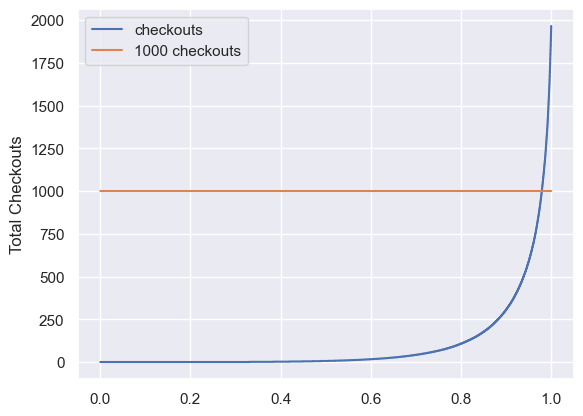

In [8]:
x = np.linspace(0, 1, len(df_clean))
y = df_clean['Total Checkouts'].sort_values()

sns.lineplot(x=x, y=y, estimator=None, label="checkouts")
sns.lineplot(x=x, y=1000, estimator=None, label="1000 checkouts").legend()

In [9]:
df_clean.to_csv("../data/df_outlier_removed.csv")

## Ausreißerentfernung II

Wir verwenden jetzt eine robustere Methode, um Ausreißer zu erkennen. Anstatt einfach die oberen/ unteren n-Prozent Werte zu entfernen, verwenden wir jetzt eine Formel, die auch zur Visualisierung der Ausreißer in Boxplots verwendet wird:

In [10]:
# eine Beobachtungen gilt als Ausreißer, wenn sie größer 
# als die Summe aus dem 75% Quantil und dem 1.5-fachen des Interquartilsabstands ist.

quantiles = df['Total Checkouts'].quantile((0.25, 0.75))
quantiles = quantiles.values # convert pandas Series to a numpy array
quantiles

array([ 0., 78.])

In [11]:
IQR = quantiles[1] - quantiles[0]
IQR

78.0

In [12]:
threshold = quantiles[1] + 1.5*IQR
threshold

195.0

In [13]:
outlier_checkouts = df['Total Checkouts'] > threshold
outlier_checkouts.mean()

0.16023516468404042

Mit dieser Methode, werden fast 15% der Beobachtungen als Ausreißer markiert!

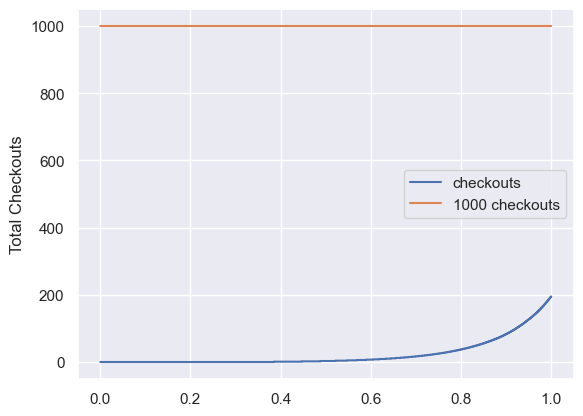

In [14]:
df_clean = df[~outlier_checkouts]

x = np.linspace(0, 1, len(df_clean))
y = df_clean['Total Checkouts'].sort_values()

sns.lineplot(x=x, y=y, estimator=None, label="checkouts")
sns.lineplot(x=x, y=1000, estimator=None, label="1000 checkouts").legend()

## Ausreißerentfernung III

Anstatt Werte nach etwas "willkürlichen" Regeln zu entfernen und damit wertvolle Informationen unberücksichtigt zu lassen, kann man auch sogenannte monotone Transformationen der Reihe durchführen, die extrem große Werte einer Reihe "stauchen", also kleiner machen. Monoton bedeutet hierbei, dass die Rangordnung der Werte dabei nicht verändert wird. Zwei solcher Kandidaten sind zum Beispiel die Logarithmus-Funktion und die Wurzel-Funktion:

<AxesSubplot:>

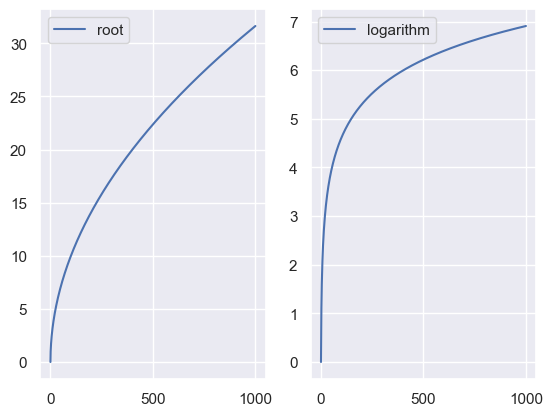

In [15]:
x = np.linspace(0, 1000, 1000)

fix, ax = plt.subplots(nrows=1, ncols=2)

sns.lineplot(x=x, y=x**0.5, estimator=None, label="root", ax = ax[0])
sns.lineplot(x=x, y=np.log(x+1), estimator=None, label="logarithm", ax = ax[1])

Man erkennt, dass beide Funktionen größere Werte stärker stauchen als kleinere Werte. Die Wurzel-Funktion staucht den Wert 1000 zu ca. 32 (32*32 = 1024). Die Logarithmus-Funktion transfomiert den Wert 1000 zu ca. 7 (e^7 = 1097)

/Users/ania/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total Checkouts', ylabel='Density'>

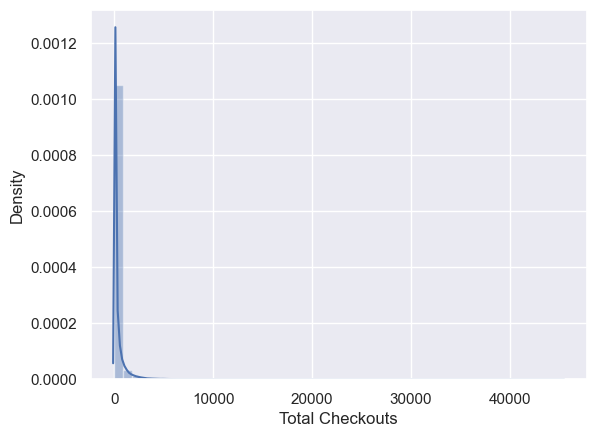

In [19]:
sns.distplot(df['Total Checkouts'])

/Users/ania/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total Checkouts Sqrt', ylabel='Density'>

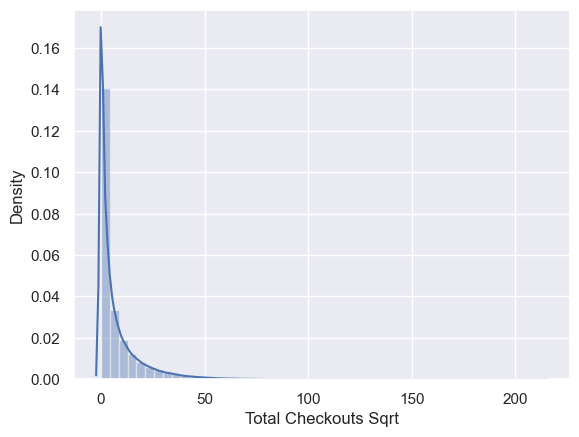

In [20]:
df['Total Checkouts Sqrt'] = df['Total Checkouts']**(0.5)
df['Total Checkouts Log'] = np.log(df['Total Checkouts']+1)

sns.distplot(df['Total Checkouts Sqrt'])

/Users/ania/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total Checkouts Log', ylabel='Density'>

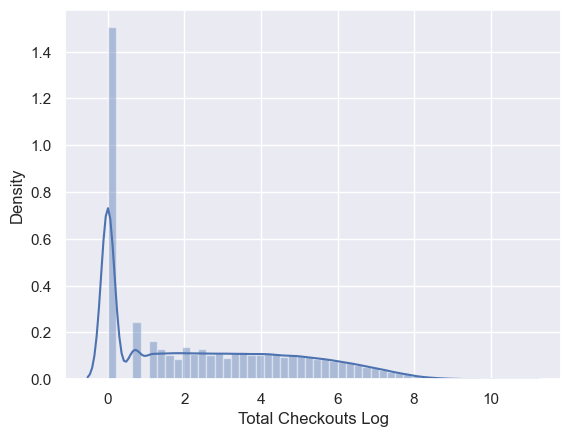

In [21]:
sns.distplot(df['Total Checkouts Log'])